### 1. Loading data set and the required libraries


In [1]:
### 1.Loading the libraries and required libraries 
# Importing ML libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

import sklearn
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
sns.set()

In [2]:
# Loading the Instacart datasets into pandas dataframes
from google.colab import drive 
drive.mount('/content/gdrive')




Mounted at /content/gdrive


In [3]:
instacart_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Algo/3. Clustering/Hierarchical Clustering/instacart_dataset_clustering2.csv', dtype={'product_name':'object', 
                                                               'aisle_id':'int16',
                                                               'department_id':'int16',
                                                               'count':'int32',
                                                               'reordered':'int64',
                                                               'reorder_rate':'float32',
                                                               'add_to_cart_mean':'float32',
                                                               'order_dow':'float32', 
                                                               'order_hour_of_day':'float32', #could also be category
                                                               'days_since_prior_order':'float32'})

In [4]:
#Let's explore the data and the associated columns
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.12
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.27
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.08
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218487,16.06
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538462,14.692308,13.54


In [5]:
#Checking for null values
instacart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13377 entries, 0 to 13376
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_name            13377 non-null  object 
 1   aisle_id                13377 non-null  int16  
 2   department_id           13377 non-null  int16  
 3   num_orders              13377 non-null  int64  
 4   num_reordered           13377 non-null  int64  
 5   reorder_rate            13377 non-null  float32
 6   add_to_cart_mean        13377 non-null  float32
 7   order_mean_dow          13377 non-null  float64
 8   order_mean_hour_of_day  13377 non-null  float64
 9   mean_day_gap_in_orders  13377 non-null  float64
dtypes: float32(2), float64(3), int16(2), int64(2), object(1)
memory usage: 783.9+ KB


In [6]:
# Aisle and department are categorical variables, let us check the numbers of categories they have
instacart_df['aisle_id'].nunique(), instacart_df['department_id'].nunique()

(134, 21)

aisle_id column has 134 categories, and department_id column has 21. When forming clusters, categorical variables with low number of values could help the algorithm deliver better results by adding another dimension. But since in this case, the number of categories is high, it won't add value to the clustering quality by the algorithm.

Let's see how the Python sees these data points:

In [7]:
#Using the describe function to check data distribution of the dataset
instacart_df.describe()

,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
count,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000
mean,70.670255,11.396651,96.935113,59.192794,0.514981,9.283619,2.762032,13.604996,17.284019
std,38.380694,6.267054,372.921094,290.603486,0.175570,2.232181,0.444830,0.865992,2.429661
min,1.000000,1.000000,11.000000,0.000000,0.000000,2.125000,0.636364,8.714286,6.363000
25%,37.000000,6.000000,17.000000,8.000000,0.400000,7.900000,2.500000,13.125000,15.810000
50%,77.000000,13.000000,31.000000,15.000000,0.533333,9.327868,2.745763,13.591837,17.220000
75%,106.000000,16.000000,72.000000,39.000000,0.642857,10.646153,3.000000,14.086957,18.750000
max,134.000000,21.000000,18726.000000,16557.000000,1.000000,19.590910,5.000000,17.562500,29.230000


Some of the interesting insights from the data distribution pattern are as follows: 

*   order_mean_dow indicates that initial days of the week have low traction.
*   order_mean_hour_of_day shows that majority of orders start coming in post noon

---



Taking a sample of data points


  *   This is because at higher number of data points, the Hierarchical clustering algorithm will through an error saying that the maximum recursion depth has been reached (because of the nature of sampling, the datapoints that are taken might be different every time the kernel is restarted)






In [8]:
sample_df = instacart_df.sample(n = 5000, random_state = 2500)
sample_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
4078,"Pita Chips, Simply Naked",107,19,80,52,0.650000,8.937500,2.762500,14.112500,18.33
3268,Corn Starch,17,13,90,3,0.033333,9.944445,2.633333,13.344444,16.83
1468,Margherita Pizza,79,1,336,213,0.633929,9.324405,2.660714,14.208333,16.72
7976,Organic Toaster Pastries Frosted Lotta Chocolo...,48,14,23,15,0.652174,8.173913,2.695652,14.956522,14.48
1406,Watermelon Chunks,123,4,854,634,0.742389,8.429743,2.526932,13.553864,14.61


### 2. Preparing the data for Clustering

1.  Dropping irrelevant columns

In [9]:
#Let us first drop unnecessary columns for our use case.
temp = sample_df[sample_df.columns.difference(['product_name', 'department_id', 'aisle_id'])]
#These columns are dropped as these features are irrelevant for our use case

In [10]:
#let us now look at the updated dataset
temp.head()

,add_to_cart_mean,mean_day_gap_in_orders,num_orders,num_reordered,order_mean_dow,order_mean_hour_of_day,reorder_rate
4078,8.937500,18.33,80,52,2.762500,14.112500,0.650000
3268,9.944445,16.83,90,3,2.633333,13.344444,0.033333
1468,9.324405,16.72,336,213,2.660714,14.208333,0.633929
7976,8.173913,14.48,23,15,2.695652,14.956522,0.652174
1406,8.429743,14.61,854,634,2.526932,13.553864,0.742389


2.  ####   Scaling with StandardScaler 

As we learned before, scaling is essential for clustering algorithms. In this demo, we'll be using *standardization* as the scaling method

In [11]:
#Scaling the values using the sklearn standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()         
temp_scaled = scaler.fit_transform(temp)


In [12]:
#Let us now print the values after standardization
temp_scaled[:5]

array([[-1.51795249e-01,  4.28841208e-01, -3.64555876e-02,
        -7.13442730e-03,  2.24088723e-03,  5.74375409e-01,
         7.60404527e-01],
       [ 2.95326486e-01, -1.93046930e-01,  1.29327607e-03,
        -2.63317146e-01, -2.87043452e-01, -3.15897254e-01,
        -2.74577072e+00],
       [ 2.00051643e-02, -2.38652061e-01,  9.29915322e-01,
         8.34608791e-01, -2.25720503e-01,  6.85458250e-01,
         6.69027650e-01],
       [-4.90856926e-01, -1.16733835e+00, -2.51624111e-01,
        -2.00578521e-01, -1.47472887e-01,  1.55270240e+00,
         7.72764990e-01],
       [-3.77258757e-01, -1.11344137e+00,  2.88530646e+00,
         3.03568888e+00, -5.25341891e-01, -7.31535381e-02,
         1.28569863e+00]])

### 3. Building Clustering Models - Part II

#### 1.   Hierarchical Clustering:

Now that our data has been sampled and scaled, we can start with applying the Hierarchical clustering algorithm. We will enable truncate_mode to the top 30 clusters so that we can make sense of the clusters that are formed.




#### 1. Single Linkage





In [14]:
import sys
sys.setrecursionlimit(10000)  # set the recursion limit to a higher value

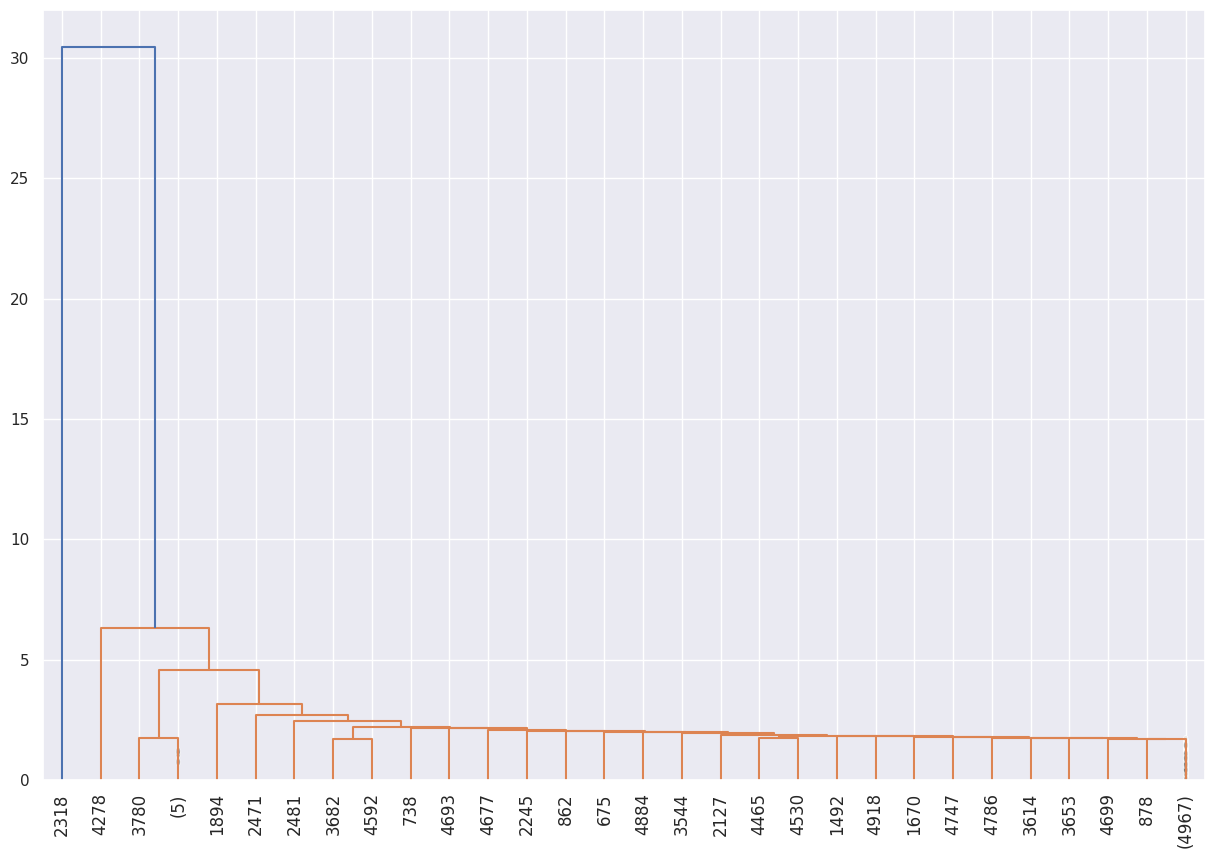

In [15]:
# Single linkage dendrogram. Here, truncate_mode is used to limit the total clusters that we can see by last 30 clusters 
#so that the resultant dendrogram makes sense.
mergings_single = linkage(temp_scaled, method="single", metric='euclidean')
plt.figure(figsize=(15,10))
dendrogram(mergings_single, truncate_mode='lastp',
            p=30,
            leaf_rotation=90,
            leaf_font_size=12,
            show_contracted=True                                  
          )
plt.show()

#### 2. Complete Linkage


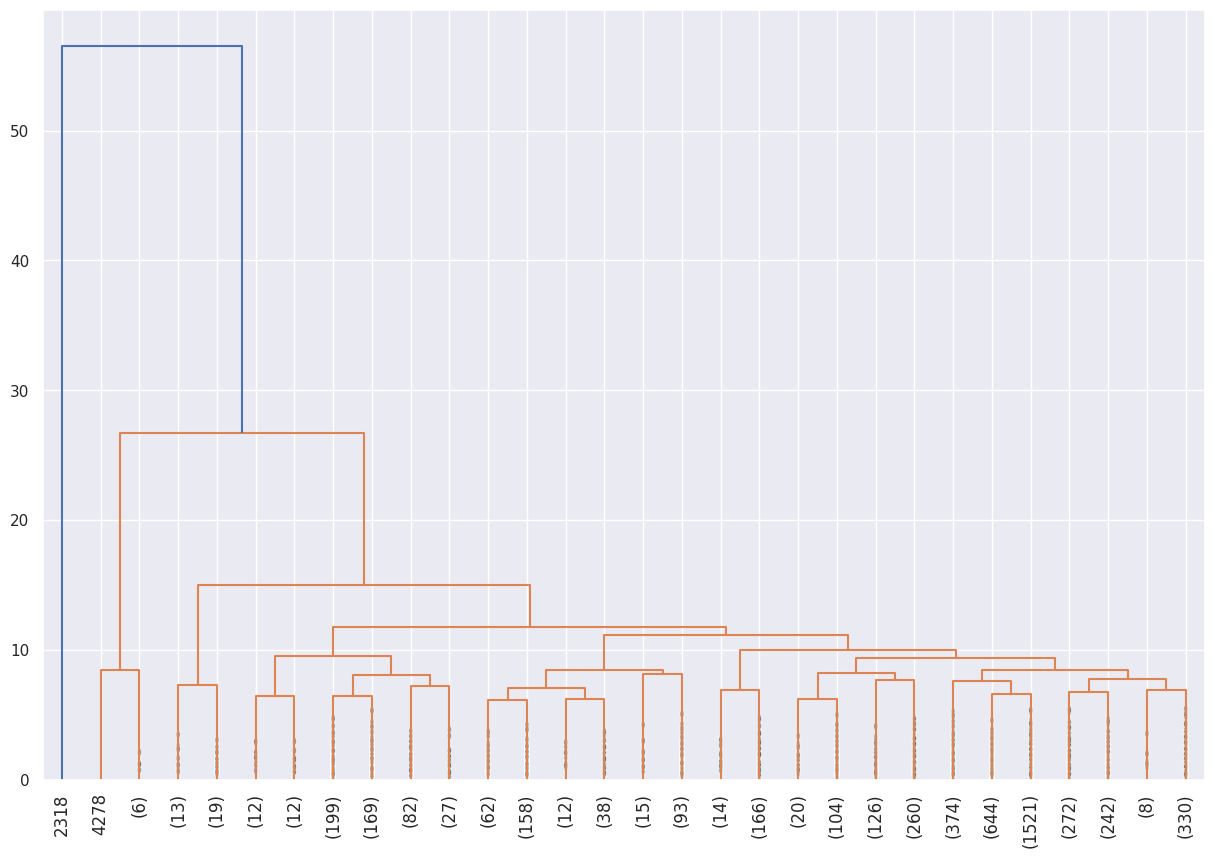

In [16]:

# Complete linkage dendrogram. Same as before, truncate_mode is used to limit the total clusters that we can see by last 30 clusters 
#so that the resultant dendrogram makes sense.
mergings_complete = linkage(temp_scaled, method="complete", metric='euclidean')
plt.figure(figsize=(15,10))
dendrogram(mergings_complete, truncate_mode='lastp',
            p=30,
            leaf_rotation=90,
            leaf_font_size=12,
            show_contracted=True
          )
plt.show()

#### 3. Average Linkage


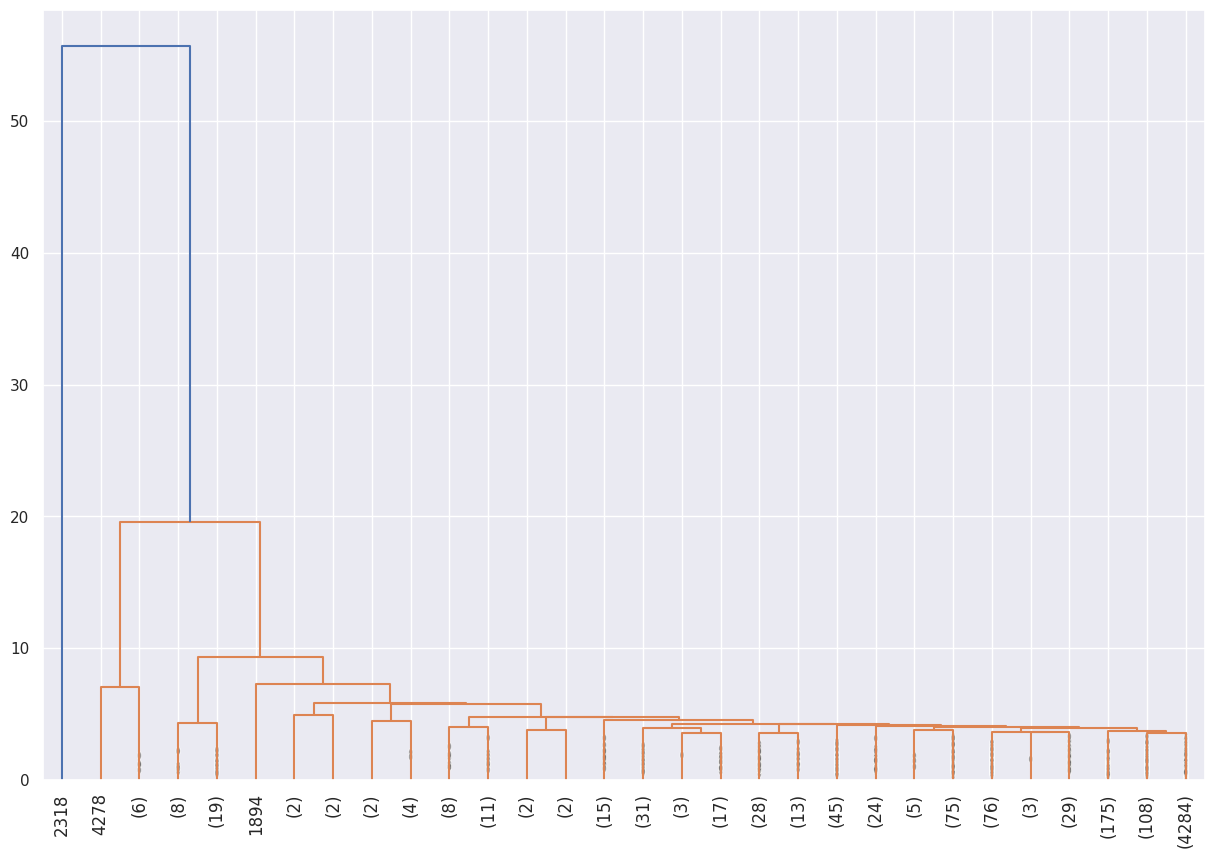

In [17]:

# Average linkage dendrogram. Same as before, truncate_mode is used to limit the total clusters that we can see by last 30 clusters 
#so that the resultant dendrogram makes sense.
mergings_average = linkage(temp_scaled, method="average", metric='euclidean')
plt.figure(figsize=(15,10))
dendrogram(mergings_average, truncate_mode='lastp',
            p=30,
            leaf_rotation=90,
            leaf_font_size=12,
            show_contracted=True
          )
plt.show()

#### Analyzing both the Hierarchical clusters above, we can see that the complete linkage Hierarchical clustering provides us with more meaninful clusters considering that we are supposed to create more than 2 clusters

#### From the complete linkage dendrogram, we can visually see 4 different clusters being made. Hence, let us take the top 4 clusters from the dendrogram

In [19]:
# Taking top 4 clusters from the dendrogram
h_labels = cut_tree(mergings_complete, n_clusters=4).reshape(-1, )
h_labels

array([0, 0, 0, ..., 0, 0, 0])

The following code gives us the distances at which the last 4 merges happen

In [20]:
print('distances for the last 4 merges:\n{}'.format(mergings_complete[-4:,2]))

distances for the last 4 merges:
[11.73465382 14.96985248 26.70203281 56.51026118]


In [21]:
# assigning the label to data points
sample_df['cluster_id'] = h_labels
sample_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id
4078,"Pita Chips, Simply Naked",107,19,80,52,0.650000,8.937500,2.762500,14.112500,18.33,0
3268,Corn Starch,17,13,90,3,0.033333,9.944445,2.633333,13.344444,16.83,0
1468,Margherita Pizza,79,1,336,213,0.633929,9.324405,2.660714,14.208333,16.72,0
7976,Organic Toaster Pastries Frosted Lotta Chocolo...,48,14,23,15,0.652174,8.173913,2.695652,14.956522,14.48,0
1406,Watermelon Chunks,123,4,854,634,0.742389,8.429743,2.526932,13.553864,14.61,0


<Axes: xlabel='cluster_id', ylabel='reorder_rate'>

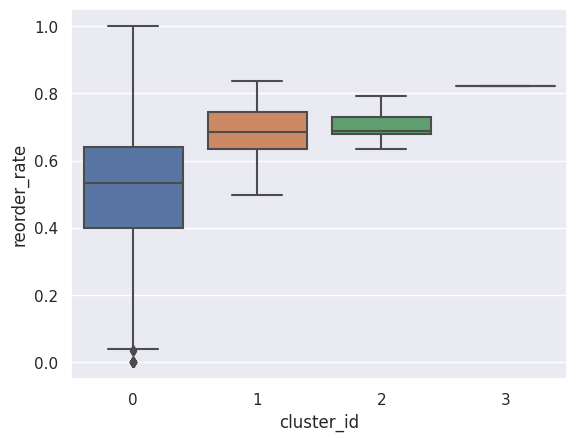

In [22]:
# Let's now plot parameter of interest (reorder_rate) with different cluster ids and see if we could find a pattern
sns.boxplot(x='cluster_id', y='reorder_rate', data=sample_df)

In [23]:
(sample_df.groupby('cluster_id')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))

# [['num_orders','num_reordered','reorder_rate','add_to_cart_mean','order_mean_dow','order_mean_hour_of_day','mean_day_gap_in_orders']].mean().reset_index()
# .merge(instacart_df['cluster_id_random'].value_counts().reset_index().rename(columns = {'index':'cluster_id_random','cluster_id_random':'num_products_in_cluster'})))

,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id,,,,,,,,
0,4960,72.203831,40.990121,0.514825,9.289719,2.762461,13.617675,17.298658
1,32,1688.750000,1155.406250,0.687771,7.990192,2.653995,13.533481,16.892781
2,7,3761.714286,2640.571429,0.704857,8.083629,2.603708,13.511954,17.018571
3,1,9784.000000,8055.000000,0.823283,7.485384,2.536590,13.552739,17.110000


#### **Summary**


**Note**: One thing to note here is that the above data does not provide us insights for the entire dataset as the data has been sampled for only 5000 products. Nevertheless, we are able to see the working of the Hierachical clustering algorithm

We have four different clusters in our complete linkage Hierarchical clustering model, each with different reorder rates and notably different number of products and average number of orders with the cluster.

* There is 1 product within (***cluster 3***) that gets reordered 82% of the time and which has the highest avg. number of orders at 9784 orders.
*Another cluster (***cluster 2***) with 7 products getting a mid-high reorder rate of 70% and which has the second highest avg. number of orders at more around 3700 orders.
*We then have another mid-high range demand group (***cluster 1***) with 32 products that get repeat orders 68% of the time and have a avg. number of orders at 1688. 
*Finally a low-mid demand group with the lowest avg. number of orders at 72 orders ( ***cluster 0***) and which consists of 4960 products that gets 51% reorders



Let's now try with entire dataset

In [25]:
#Let us first drop unnecessary columns for our use case.
temp = instacart_df[instacart_df.columns.difference(['product_name', 'department_id', 'aisle_id'])]
#These columns are dropped as these features are irrelevant for our use case

In [26]:
#Scaling the values using the sklearn standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()         
temp_scaled = scaler.fit_transform(temp)

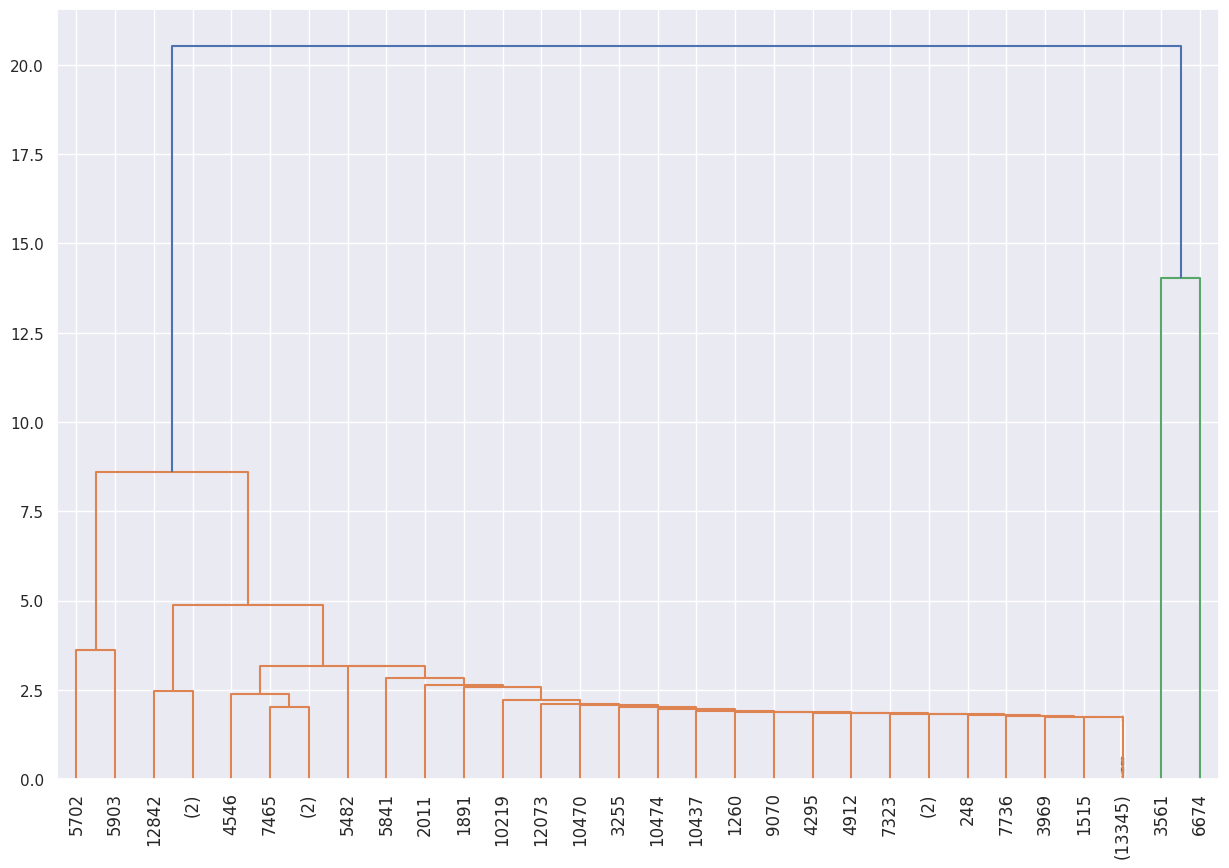

In [27]:
# Single linkage dendrogram. Here, truncate_mode is used to limit the total clusters that we can see by last 30 clusters 
#so that the resultant dendrogram makes sense.
mergings_single = linkage(temp_scaled, method="single", metric='euclidean')
plt.figure(figsize=(15,10))
dendrogram(mergings_single, truncate_mode='lastp',
            p=30,
            leaf_rotation=90,
            leaf_font_size=12,
            show_contracted=True                                  
          )
plt.show()

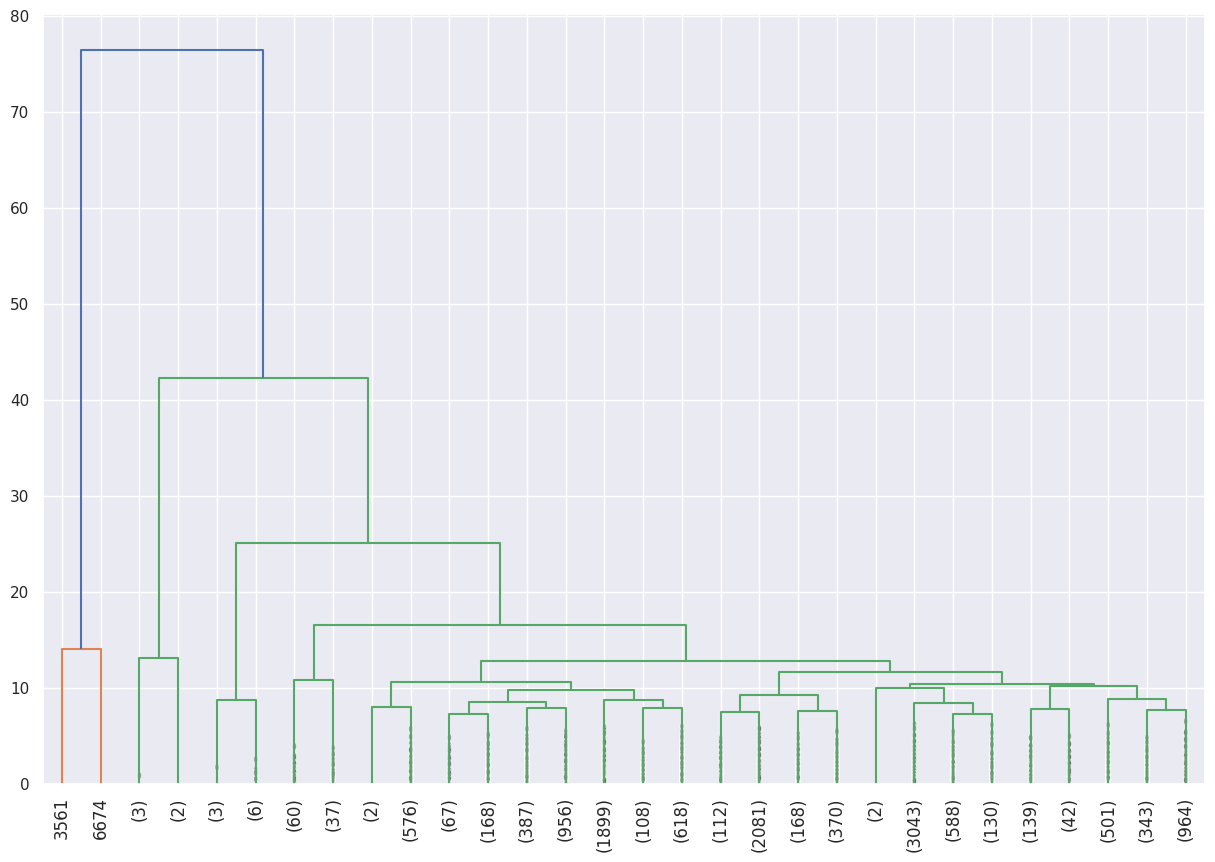

In [28]:
# Complete linkage dendrogram. Same as before, truncate_mode is used to limit the total clusters that we can see by last 30 clusters 
#so that the resultant dendrogram makes sense.
mergings_complete = linkage(temp_scaled, method="complete", metric='euclidean')
plt.figure(figsize=(15,10))
dendrogram(mergings_complete, truncate_mode='lastp',
            p=30,
            leaf_rotation=90,
            leaf_font_size=12,
            show_contracted=True
          )
plt.show()

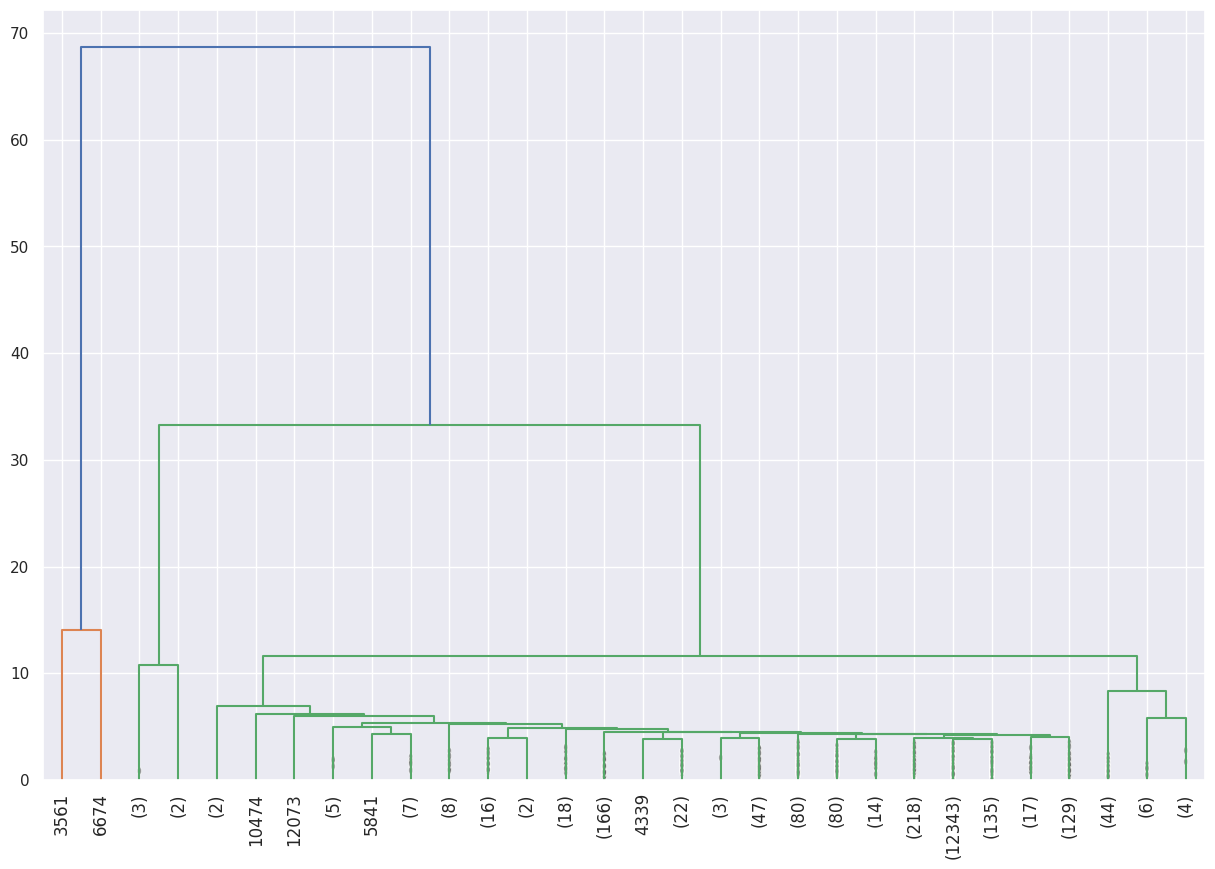

In [29]:

# Average linkage dendrogram. Same as before, truncate_mode is used to limit the total clusters that we can see by last 30 clusters 
#so that the resultant dendrogram makes sense.
mergings_average = linkage(temp_scaled, method="average", metric='euclidean')
plt.figure(figsize=(15,10))
dendrogram(mergings_average, truncate_mode='lastp',
            p=30,
            leaf_rotation=90,
            leaf_font_size=12,
            show_contracted=True
          )
plt.show()

In [30]:
# Taking top 4 clusters from the dendrogram
h_labels = cut_tree(mergings_complete, n_clusters=4).reshape(-1, )
h_labels

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
# assigning the label to data points
instacart_df['cluster_id'] = h_labels
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.12,0
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.27,0
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.08,0
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218487,16.06,0
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538462,14.692308,13.54,0


<Axes: xlabel='cluster_id', ylabel='reorder_rate'>

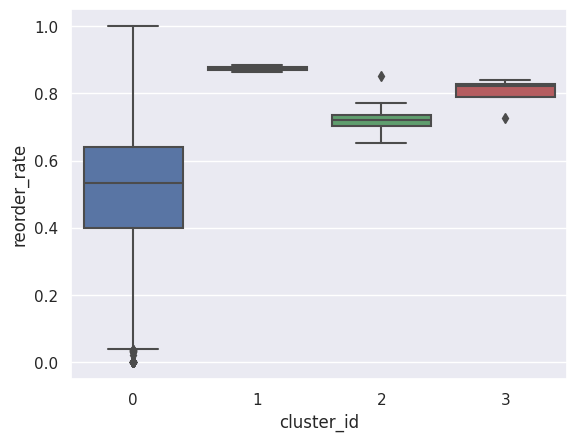

In [32]:
# Let's now plot parameter of interest (reorder_rate) with different cluster ids and see if we could find a pattern
sns.boxplot(x='cluster_id', y='reorder_rate', data=instacart_df)

In [33]:
(instacart_df.groupby('cluster_id')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))

,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id,,,,,,,,
0,13361,87.821495,51.926428,0.514676,9.285611,2.762227,13.605019,17.285067
1,2,17103.000000,14959.500000,0.873675,4.861458,2.627131,13.551485,16.230000
2,9,5066.333333,3696.111111,0.728706,8.358684,2.611565,13.597733,16.383333
3,5,8703.000000,6969.800000,0.801973,7.391271,2.567882,13.578165,16.526200
